# Exercise Round 11

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from tqdm.auto import tqdm  # pip install tqdm; pip install ipywidgets

## Exercise 1

We consider a linear Gaussian state-space model
\begin{equation}
    \left\{
        \begin{split}
            x_n &= x_{n-1} + q_{n-1} \\
            y_n &= x_{n} + r_{n}
        \end{split}
    \right.
\end{equation}
with $x_0 \sim N(0,1)$, $q_{n-1} \sim N(0,1)$, and $r_{n} \sim N(0,1)$.


(a) Write down the params

In [2]:
T = 50


(a1) Simulate from the model

In [3]:
def simulate_lgssm(T: int):
    """T is the number of observations"""
    
    # create the arrays
    xs = np.empty((T + 1,))
    ys = np.empty((T,))

    # inital state
    x = np.random.randn()
    xs[0] = x

    # loop over the propagation-emission loop
    for i in range(T):
        x = x + np.random.randn()
        y = x + np.random.randn()
        xs[i+1] = x
        ys[i] = y

    return xs, ys

(a2) Implement a Kalman filter for this:

In [4]:
def kf(ys):

    def predict(mf, Pf):
        mp = mf  # F mf
        Pp = Pf + 1.  # F P_f F^T + Q
        return mp, Pp

    def update(mp, Pp, y):
        res = y - mp  # y - G m_p
        S = Pp + 1.  # G P_p G^T + R
        K = Pp / S  # P G^T S^{-1}
        mf = mp + K * res  # m_f = m_p + K res
        Pf = Pp - S * K ** 2  # P_f = P_p - K S K^T
        return mf, Pf

    mfs = np.empty((T+1,))
    Pfs = np.empty((T+1,))

    # initial state
    mfs[0], Pfs[0] = mf, Pf = 0., 1.

    # one prediction step
    mp, Pp = predict(mf, Pf)

    for i, y in enumerate(ys):
        mfs[i+1], Pfs[i+1] = mf, Pf = update(mp, Pp, y)
        mp, Pp = predict(mf, Pf)
    
    return mfs, Pfs

(a3) Implement a bootstrap particle filter for this:

In [5]:
def pf(ys, N, fast_multinomial=False):
    # This algorithm sadly happens to have complexity $O(N \log(N))$, 
    # the main bottleneck being how to resample indices. While solutions exist
    # We kept it this way for ease of illustration. You may trigger a faster
    # behaviour by calling it with fast_multinomial=True instead, 
    # however the searchsorted still has $O(N \log(N))$ complexity

    def predict(x, eps):
        return x + eps  # simply propagate

    def update(x, y):
        w = stats.norm.pdf(x - y)  # compute your observation weights
        W = w / w.sum()  # normalise

        if not fast_multinomial:
        # sample ancestor indices based on W (multinomial is used here)
        # the below reads as "sample N (second argument) elements 
        # from {0, ..., N-1} (first argument) where P(A[i] = j) = W_j (p=W argument)"
            A = np.random.choice(N, N, p=W)
        else:
            vs = np.random.rand(N+1)
            us = np.log(vs[1:] / vs[:-1])  # pre sorted uniforms
            cumsum = np.cumsum(W)
            A = np.searchsorted(cumsum, us)
            

        return x[A]  # just apply the resampling index
        
    particles = np.empty((T+1, N))

    # initial state
    particles[0] = x = np.random.randn(N)
    epsilons = np.random.randn(T+1, N)  # pregenerate the Gaussians we will need

    # one prediction step
    x = predict(x, epsilons[0])

    for i in range(T):
        particles[i+1] = x = update(x, ys[i])
        x = predict(x, epsilons[i+1])
    
    return particles

(a4) We can now compare:

In [6]:
true_xs, observations = simulate_lgssm(T)

%time kf_ms, kf_Ps = kf(observations)

%time pf_xs = pf(observations, 100)

pf_ms = pf_xs.mean(1)
pf_Ps = pf_xs.var(1)

CPU times: user 123 µs, sys: 18 µs, total: 141 µs
Wall time: 144 µs
CPU times: user 15.8 ms, sys: 76 µs, total: 15.9 ms
Wall time: 14.3 ms


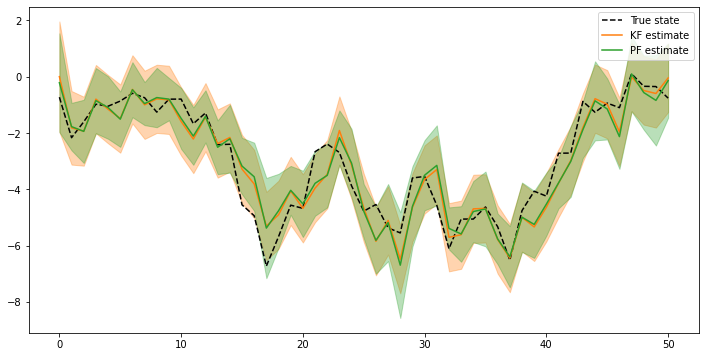

In [7]:
fig, ax = plt.subplots(figsize=(12, 6))
linspace = np.arange(T+1)
ax.plot(linspace, true_xs, color="k", linestyle="--", label="True state")
ax.plot(linspace, kf_ms, color="tab:orange", label="KF estimate")
ax.plot(linspace, pf_ms, color="tab:green", label="PF estimate")

ax.fill_between(linspace, 
                kf_ms - 1.96 * kf_Ps,
                kf_ms + 1.96 * kf_Ps, 
                color="tab:orange", alpha=0.33)
ax.fill_between(linspace,
        pf_ms - 1.96 * pf_Ps,
        pf_ms + 1.96 * pf_Ps,  
        color="tab:green", alpha=0.33)

_ = ax.legend()

The Kalman filter and the particle filter recover approximately the same mean and distribution, however, in this case, the particle filter is much times slower than the Kalman filter.

(b) We can now check how the mean and variance estimates of the particle filter solution behave as $N \to \infty$. To do this we compute the average RMSE of the mean and variance estimate, i.e., for, e.g., the mean, we compute
\begin{align}
    \left(\frac{1}{T+1} \sum_{t=0}^T (\mathbb{E}_{PF}[X(t)] - \mathbb{E}_{KF}[X(t)])^2\right)^{1/2}
\end{align}
and similar for the variance estimate

In [13]:
Ns = np.logspace(2, 5, num=50, base=10, dtype=int)

def test_function(N):
    pf_xs = pf(observations, N)

    pf_ms = pf_xs.mean(1)
    pf_Ps = pf_xs.var(1)
    m_res = np.sqrt(np.mean(np.square(pf_ms - kf_ms)))
    P_res = np.sqrt(np.mean(np.square(pf_Ps - kf_Ps)))
    return m_res, P_res

mean_rmses = np.empty_like(Ns, dtype=float)
var_rmses = np.empty_like(Ns, dtype=float)

for i, N in enumerate(tqdm(Ns)):
    mean_rmses[i], var_rmses[i] = test_function(N)

  0%|          | 0/50 [00:00<?, ?it/s]

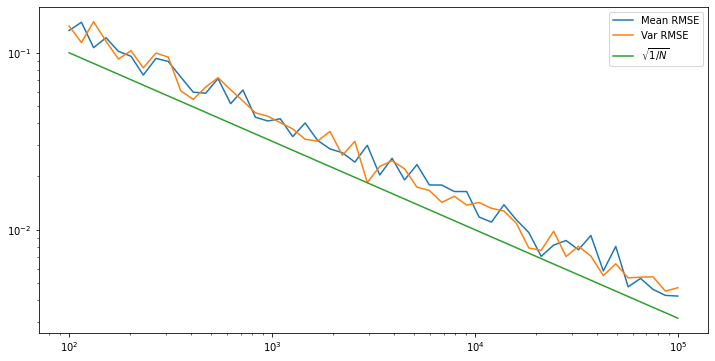

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.loglog(Ns, mean_rmses, label="Mean RMSE", color="tab:blue")
ax.loglog(Ns, var_rmses, label="Var RMSE", color="tab:orange")
ax.loglog(Ns, 1 / np.sqrt(Ns), label=r"$\sqrt{1/N}$", color="tab:green")
_ = ax.legend()

## Exercise 2

EKF vs PF tracking of robot with position measurements.

Euler-Maruyama and linearization based approximation of
$$
   dp^x/dt = v \, \cos(\phi) + w_1 \\
   dp^y/dt = v \, \sin(\phi) + w_2 \\
   d\phi/dt = \omega + w_3
$$
is
$$
   p^x_n = p^x_{n-1} + v_{n-1} \, \cos(\phi_{n-1}) \, \Delta t + e_1 \\
   p^y_n = p^y_{n-1} + v_{n-1} \, \sin(\phi_{n-1}) \, \Delta t + e_2 \\
   \phi_n = \phi_{n-1} + \omega_{n-1} \, \Delta t + e_3
$$
with $e \sim N(0,Q)$ with $Q = \Delta t \, \mathrm{diag}(q_1,q_2,q_3)$. We assume that $v$ and $\omega$ are constant on the interval (ZOH). The
measurements are
$$
   y_1 = p^x + r_1 \\
   y_2 = p^y + r_2
$$

(a)

(a1) we get some data

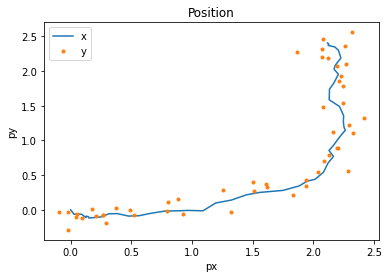

In [15]:
%matplotlib inline
import numpy as np
import scipy.linalg as linalg
import scipy.integrate as integrate
import math
import matplotlib.pyplot as plt

def fr(x,u):
    return np.array([u[0] * np.cos(x[2]), u[0] * np.sin(x[2]), u[1]])

x0 = np.array([0,0,0])
dt = 0.1
tr = np.arange(0,5+dt,dt)

V = np.zeros((tr.shape[0],))
Omega = np.zeros((tr.shape[0],))
for k in range(tr.shape[0]):
    if tr[k] < 1:
        V[k] = tr[k]
    elif tr[k] >= 4:
        V[k] = 5 - tr[k]
    else:
        V[k] = 1
        
    if tr[k] < 2 or tr[k] >= 3:
        Omega[k] = 0
    else:
        Omega[k] = math.pi / 2

xs = np.zeros((tr.shape[0],3))
ys = np.zeros((tr.shape[0],2))

cx = x0
q1 = 0.01
q2 = 0.01
q3 = 0.01
G  = np.array([[1,0,0],[0,1,0]])
sd = 0.1
R = np.array([[sd**2]])

ys[0,:] = G @ cx + sd * np.random.normal(size=(2,))
for k in range(1,tr.shape[0]):
    u  = np.array([V[k-1],Omega[k-1]])
    dt = tr[k] - tr[k-1]
    v  = np.diag(np.sqrt(dt * np.array([q1,q2,q3]))) @ np.random.normal(size=(3,))
    cx = cx + dt * fr(cx,u) + v
    ys[k,:] = G @ cx + sd * np.random.normal(size=(2,))
    xs[k,:] = cx;
    
plt.clf()
plt.plot(xs[:,0],xs[:,1],ys[:,0],ys[:,1],'.')
plt.xlabel('px')
plt.ylabel('py')
plt.title('Position')
plt.legend(['x','y'])

(a2) We write our particle filter

Let us define our transition and observations models

In [16]:
m0 = np.zeros((3,))
P0 = 0.1**2 * np.eye(3)
q_diag = dt * np.array([q1,q2,q3])

def pf_robot(ys, N):

    T, d_y = ys.shape
    d_x = m0.shape[0]
    
    epsilons = np.sqrt(q_diag[None, None, :]) * np.random.randn(T+1, N, d_x)
    
    def f(p, eps, v, w, dt):
        # Propagate the state through the transition with noise epsilon
        px  = p[:,0]
        py  = p[:,1]
        phi = p[:,2]
        px = px + v * np.cos(phi) * dt + eps[:,0]
        py = py + v * np.sin(phi) * dt + eps[:,1]
        phi = phi + w * dt + eps[:,2]
        p = np.stack([px, py, phi], axis=-1)
        return p

    def g(p, obs, sd):
        # Compute the likelihood of an observation
        px = p[:,0]
        py = p[:,1]
        obsx, obsy = obs
        x_part = stats.norm.logpdf(px - obsx, scale=sd)
        y_part = stats.norm.logpdf(py - obsy, scale=sd)
        return np.exp(x_part + y_part)


    def predict(t, x):
        eps = epsilons[t]
        v = V[t]
        w = Omega[t]
        return f(x, eps, v, w, dt)

    def update(t, x):
        w = g(x, ys[t], sd)  # compute your observation weights
        W = w / w.sum()  # normalise

#        vs = np.random.rand(N+1)
#        us = np.log(vs[1:] / vs[:-1])
#        cumsum = np.cumsum(W)
#        A = np.searchsorted(cumsum, us)
        A = np.random.choice(N, N, p=W)
            
        return x[A]  # just apply the resampling index
        
    particles = np.empty((T+1, N, d_x))
    x = particles[0] = stats.multivariate_normal.rvs(m0, P0, N)
    
    for i in range(T):
        particles[i+1] = x = update(i, x)
        x = predict(i, x)
    
    return particles

0.05521947605463201
0.09843664257051069


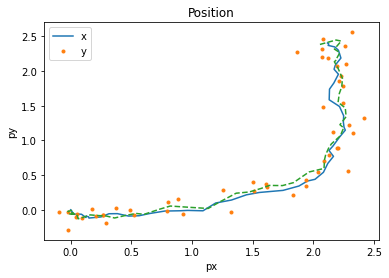

In [17]:
pf_robot_xs = pf_robot(ys, 100)
pfr_m = pf_robot_xs.mean(1)
pfr_V = pf_robot_xs.var(1)

print(np.sqrt(((pfr_m[1:,0:2]-xs[:,0:2])**2).mean()))
print(np.sqrt(((ys-xs[:,0:2])**2).mean()))
plt.clf()
plt.plot(xs[:,0],xs[:,1],ys[:,0],ys[:,1],'.',pfr_m[:,0],pfr_m[:,1],'--')
plt.xlabel('px')
plt.ylabel('py')
plt.title('Position')
plt.legend(['x','y'])

(c) Extended Kalman filter for the robot

In [18]:
def f_fun(x,v,omega,dt):
    return np.array([x[0] + v * np.cos(x[2]) * dt, x[1] + v * np.sin(x[2]) * dt, x[2] + omega * dt])

def F_fun(x,v,omega,dt):
    return np.array([[1,0,-dt*v*np.sin(x[2])],[0,1,dt*v*np.cos(x[2])],[0,0,1]])
                     
# Check derivative with autodiff
import autograd.numpy as anp   # Thinly-wrapped version of Numpy # install it: pip install autograd
from autograd import jacobian

v = np.random.normal()
omega = np.random.normal()
dt = 0.1
def af_fun(x):
    return anp.array([x[0] + v * anp.cos(x[2]) * dt, x[1] + v * anp.sin(x[2]) * dt, x[2] + omega * dt])

x = np.random.normal(size=(3,))
J1 = F_fun(x,v,omega,dt)
J2 = jacobian(af_fun)(x)
print(J1)
print(J2)
print(linalg.norm(J1 - J2))

[[ 1.          0.         -0.04525629]
 [ 0.          1.         -0.03719352]
 [ 0.          0.          1.        ]]
[[ 1.          0.         -0.04525629]
 [ 0.          1.         -0.03719352]
 [ 0.          0.          1.        ]]
0.0


0.07416824272931241
0.09843664257051069


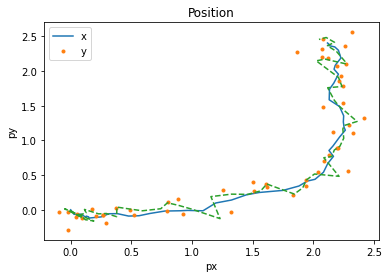

In [19]:
m = m0
P = P0
Q = np.diag(dt * np.array([q1,q2,q3]))
ekf_m = np.zeros((ys.shape[0],m.shape[0]))
ekf_P = np.zeros((ys.shape[0],P.shape[0],P.shape[1]))
for n in range(ys.shape[0]):
    # Prediction
    if n > 0:
        f = f_fun(m,V[n-1],Omega[n-1],dt)
        F = F_fun(m,V[n-1],Omega[n-1],dt)
        m = f
        P = F @ P @ F.T + Q
    # Update
    S = G @ P @ G.T + R
    K = P @ G.T @ linalg.inv(S)
    m = m + K @ (ys[n] - G @ m)
    P = P - K @ S @ K.T
    ekf_m[n,:] = m
    ekf_P[n,:,:] = P

print(np.sqrt(((ekf_m[:,0:2]-xs[:,0:2])**2).mean()))
print(np.sqrt(((ys-xs[:,0:2])**2).mean()))
plt.clf()
plt.plot(xs[:,0],xs[:,1],ys[:,0],ys[:,1],'.',ekf_m[:,0],ekf_m[:,1],'--')
plt.xlabel('px')
plt.ylabel('py')
plt.title('Position')
plt.legend(['x','y'])

(d)

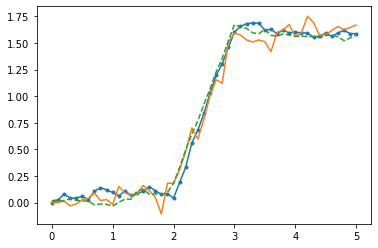

In [20]:
plt.clf()
plt.plot(tr,xs[:,2],'.-',tr,ekf_m[:,2],tr,pfr_m[1:,2],'--')

## Exercise 3

The measurement model is now
$$
y_1 = \sqrt{(x_1 - s_x)^2 + (x_2 - s_y)^2} + r_1 \\
y_2 = \arctan\left( \frac{x_2 - s_y}{x_1 - s_x} \right) + r_2
$$

Text(0.5, 1.0, 'Position')

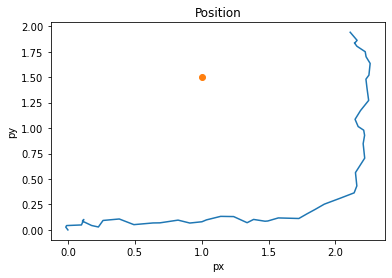

In [21]:
%matplotlib inline
import numpy as np
import scipy.linalg as linalg
import scipy.integrate as integrate
import math
import matplotlib.pyplot as plt

def fr(x,u):
    return np.array([u[0] * np.cos(x[2]), u[0] * np.sin(x[2]), u[1]])

sx = 1
sy = 1.5

def g_fun(x):
    return np.array([np.sqrt((x[0]-sx)**2 + (x[1]-sy)**2), np.arctan2(sy-x[1],sx-x[0])-x[2]])

x0 = np.array([0,0,0])
dt = 0.1
tr = np.arange(0,5+dt,dt)

V = np.zeros((tr.shape[0],))
Omega = np.zeros((tr.shape[0],))
for k in range(tr.shape[0]):
    if tr[k] < 1:
        V[k] = tr[k]
    elif tr[k] >= 4:
        V[k] = 5 - tr[k]
    else:
        V[k] = 1
        
    if tr[k] < 2 or tr[k] >= 3:
        Omega[k] = 0
    else:
        Omega[k] = math.pi / 2

xs = np.zeros((tr.shape[0],3))
ys = np.zeros((tr.shape[0],2))

cx = x0
q1 = 0.01
q2 = 0.01
q3 = 0.01
sd = 0.1
R = sd**2 * np.eye(2)

ys[0,:] = g_fun(cx) + sd * np.random.normal(size=(2,))
for k in range(1,tr.shape[0]):
    u  = np.array([V[k-1],Omega[k-1]])
    dt = tr[k] - tr[k-1]
    v  = np.diag(np.sqrt(dt * np.array([q1,q2,q3]))) @ np.random.normal(size=(3,))
    cx = cx + dt * fr(cx,u) + v
    ys[k,:] = g_fun(cx) + sd * np.random.normal(size=(2,))
    xs[k,:] = cx;
    
plt.clf()
plt.plot(xs[:,0],xs[:,1],sx,sy,'o')
plt.xlabel('px')
plt.ylabel('py')
plt.title('Position')


Text(0.5, 1.0, 'Measurements')

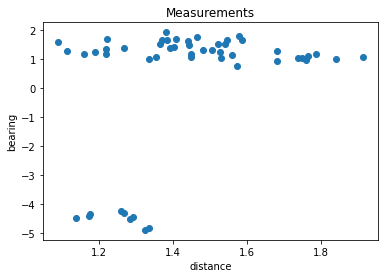

In [22]:
plt.clf()
plt.scatter(ys[:,0],ys[:,1])
plt.xlabel('distance')
plt.ylabel('bearing')
plt.title('Measurements')


In [23]:
m0 = np.zeros((3,))
P0 = 0.1**2 * np.eye(3)
q_diag = dt * np.array([q1,q2,q3])

def pf_robot2(ys, N):

    T, d_y = ys.shape
    d_x = m0.shape[0]
    
    epsilons = np.sqrt(q_diag[None, None, :]) * np.random.randn(T+1, N, d_x)
    
    def f(p, eps, v, w, dt):
        # Propagate the state through the transition with noise epsilon
        px  = p[:,0]
        py  = p[:,1]
        phi = p[:,2]
        px = px + v * np.cos(phi) * dt + eps[:,0]
        py = py + v * np.sin(phi) * dt + eps[:,1]
        phi = phi + w * dt + eps[:,2]
        p = np.stack([px, py, phi], axis=-1)
        return p

    def g(p, obs, sd):
        # Compute the likelihood of an observation
        px  = p[:,0]
        py  = p[:,1]
        phi = p[:,2]
        dst = np.sqrt((px-sx)**2 + (py-sy)**2)
        ang = np.arctan2(sy-py,sx-px)-phi
        obsd, obsa = obs
        delta = ang - obsa
        for i in range(delta.shape[0]):
            if delta[i] > np.pi:
                delta[i] = delta[i] - 2*np.pi
            elif delta[i] < -np.pi:
                delta[i] = delta[i] + 2*np.pi
        
        x_part = stats.norm.logpdf(dst - obsd, scale=sd)
        y_part = stats.norm.logpdf(delta, scale=sd)
        return np.exp(x_part + y_part)


    def predict(t, x):
        eps = epsilons[t]
        v = V[t]
        w = Omega[t]
        return f(x, eps, v, w, dt)

    def update(t, x):
        w = g(x, ys[t], sd)  # compute your observation weights
        W = w / w.sum()  # normalise

#        vs = np.random.rand(N+1)
#        us = np.log(vs[1:] / vs[:-1])
#        cumsum = np.cumsum(W)
#        A = np.searchsorted(cumsum, us)
        A = np.random.choice(N, N, p=W)
            
        return x[A]  # just apply the resampling index
        
    particles = np.empty((T+1, N, d_x))
    x = particles[0] = stats.multivariate_normal.rvs(m0, P0, N)
    
    for i in range(T):
        particles[i+1] = x = update(i, x)
        x = predict(i, x)
    
    return particles

0.11437021361732776


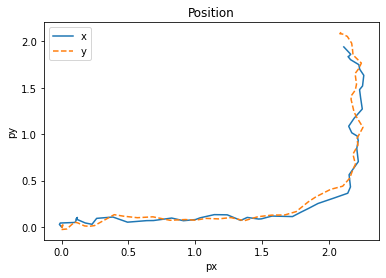

In [26]:
pf_robot_xs = pf_robot2(ys, 1000)
pfr_m = pf_robot_xs.mean(1)
pfr_V = pf_robot_xs.var(1)

print(np.sqrt(((pfr_m[1:,0:2]-xs[:,0:2])**2).mean()))
plt.clf()
plt.plot(xs[:,0],xs[:,1],pfr_m[:,0],pfr_m[:,1],'--')
plt.xlabel('px')
plt.ylabel('py')
plt.title('Position')
plt.legend(['x','y'])

In [27]:
def G_fun(x):
    return np.array([[(x[0]-sx)/np.sqrt((x[0]-sx)**2 + (x[1]-sy)**2),(x[1]-sy)/np.sqrt((x[0]-sx)**2 + (x[1]-sy)**2),0],
                    [(sy-x[1])/((x[0]-sx)**2 + (x[1]-sy)**2),(x[0]-sx)/((x[0]-sx)**2 + (x[1]-sy)**2),-1]])

# Check derivative with autodiff
import autograd.numpy as anp   # Thinly-wrapped version of Numpy # install it: pip install autograd
from autograd import jacobian

def ag_fun(x):
    return anp.array([anp.sqrt((x[0]-sx)**2 + (x[1]-sy)**2), anp.arctan2(sy-x[1],sx-x[0])-x[2]])

x = np.random.normal(size=(3,))
J1 = G_fun(x)
J2 = jacobian(ag_fun)(x)
print(J1)
print(J2)
print(linalg.norm(J1 - J2))

[[ 0.51536856 -0.85696864  0.        ]
 [ 0.85337781  0.51320908 -1.        ]]
[[ 0.51536856 -0.85696864  0.        ]
 [ 0.85337781  0.51320908 -1.        ]]
1.1102230246251565e-16


0.11706603480886717
2.100373700287108


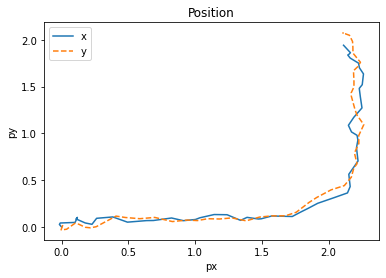

In [29]:
def f_fun(x,v,omega,dt):
    return np.array([x[0] + v * np.cos(x[2]) * dt, x[1] + v * np.sin(x[2]) * dt, x[2] + omega * dt])

def F_fun(x,v,omega,dt):
    return np.array([[1,0,-dt*v*np.sin(x[2])],[0,1,dt*v*np.cos(x[2])],[0,0,1]])

Q  = np.diag(dt * np.array([q1,q2,q3]))

m = m0
P = P0
ekf_m = np.zeros((ys.shape[0],m.shape[0]))
ekf_P = np.zeros((ys.shape[0],P.shape[0],P.shape[1]))
for n in range(ys.shape[0]):
    # Prediction
    if n > 0:
        f = f_fun(m,V[n-1],Omega[n-1],dt)
        F = F_fun(m,V[n-1],Omega[n-1],dt)
        m = f
        P = F @ P @ F.T + Q
    # Update
    g = g_fun(m)
    G = G_fun(m)
    S = G @ P @ G.T + R
    K = P @ G.T @ linalg.inv(S)
    nu = ys[n] - g
    if nu[1] > np.pi:
        nu[1] = nu[1] - 2*np.pi
    elif nu[1] < -np.pi:
        nu[1] = nu[1] + 2*np.pi
    
    m = m + K @ nu
    P = P - K @ S @ K.T
    ekf_m[n,:] = m
    ekf_P[n,:,:] = P

print(np.sqrt(((ekf_m[:,0:2]-xs[:,0:2])**2).mean()))
print(np.sqrt(((ys-xs[:,0:2])**2).mean()))
plt.clf()
plt.plot(xs[:,0],xs[:,1],ekf_m[:,0],ekf_m[:,1],'--')
plt.xlabel('px')
plt.ylabel('py')
plt.title('Position')
plt.legend(['x','y'])

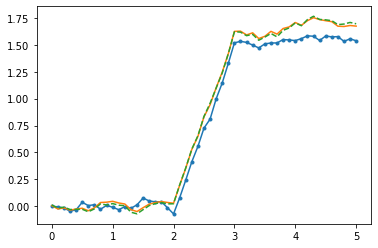

In [30]:
plt.clf()
plt.plot(tr,xs[:,2],'.-',tr,ekf_m[:,2],tr,pfr_m[1:,2],'--')